In [ ]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'feature/explainability-timing'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy lime
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive

    drive.mount('/content/drive')

#### Explainability of CNN using SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In this notebook, we'll use SHAP to explain our CNN-based spam detection model:
1. Generate SHAP explanations for individual predictions
2. Visualize which features (words) contribute most to the model's decisions
3. Compare SHAP with LIME explanations
4. Evaluate explanation quality using metrics like AUC-Del and AUC-Ins

In [1]:
import sys
import torch
import pandas as pd
import shap

from explainability.CnnShapExplainer import CnnShapExplainer

# Add the parent directory to the path for imports
sys.path.append('..')
from utils.constants import DATA_PATH, GLOVE_PATH

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Using device: cuda


In [2]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from utils.functions import set_seed, build_vocab, create_background_texts

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [4]:
from preprocess.data_loader import load_glove_embeddings

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [5]:
from models.cnn import SpamCNN

# Load the trained CNN model
model_path = DATA_PATH + '/trained-models/spam_cnn_final.pt'
cnn_model = SpamCNN(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                    pretrained_embeddings=pretrained_embeddings)
cnn_model.load(model_path, map_location=device)  # map_location handled in load()
cnn_model = cnn_model
cnn_model.eval()

SpamCNN(
  (embedding): Embedding(25245, 300)
  (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
samples = (150, 357, 402 , 416, 417, 604)
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"


In [7]:
# Initialize the SHAP wrapper
explainer = CnnShapExplainer(model=cnn_model, word_to_idx=word2idx, idx_to_word=idx2word, max_length=256)

In [8]:
from explainability.ExplanationQualityMetrics import ExplanationQualityMetrics

background_texts = create_background_texts(train_df)
explainer.setup_explainer(background_texts, n_background=100)
quality_evaluator = ExplanationQualityMetrics(explainer)

Selected 50 spam and 50 ham emails for background
Setting up SHAP explainer with 100 background samples...
Background data shape: (100, 256)
SHAP explainer ready!


  0%|          | 0/1 [00:00<?, ?it/s]

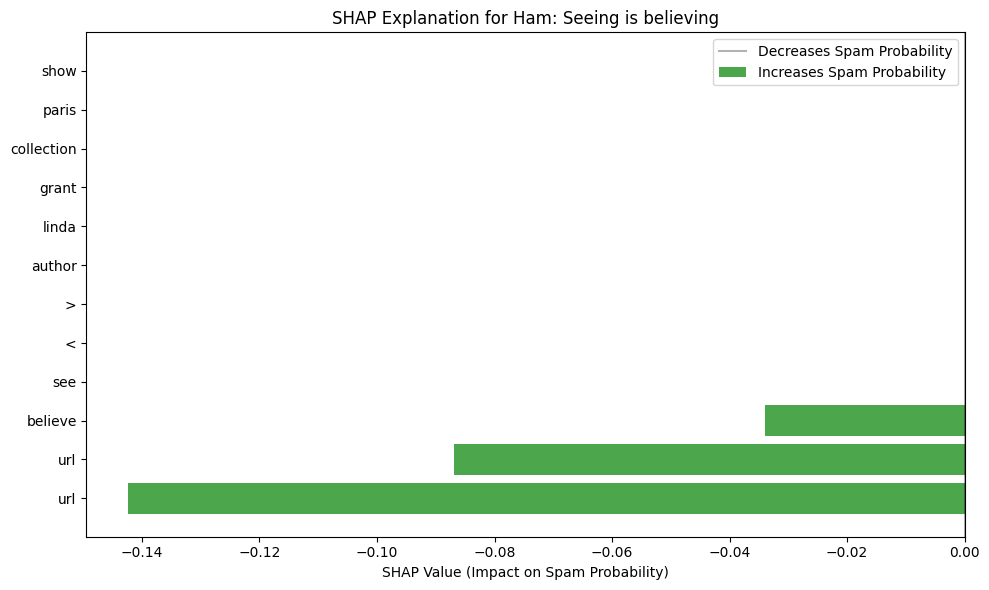

Top contributing features:
'url': -0.1423 (towards ham)
'url': -0.0869 (towards ham)
'believe': -0.0340 (towards ham)
'see': 0.0000 (towards ham)
'<': 0.0000 (towards ham)
'>': 0.0000 (towards ham)
'author': 0.0000 (towards ham)
'linda': 0.0000 (towards ham)
'grant': 0.0000 (towards ham)
'collection': 0.0000 (towards ham)


  0%|          | 0/1 [00:00<?, ?it/s]

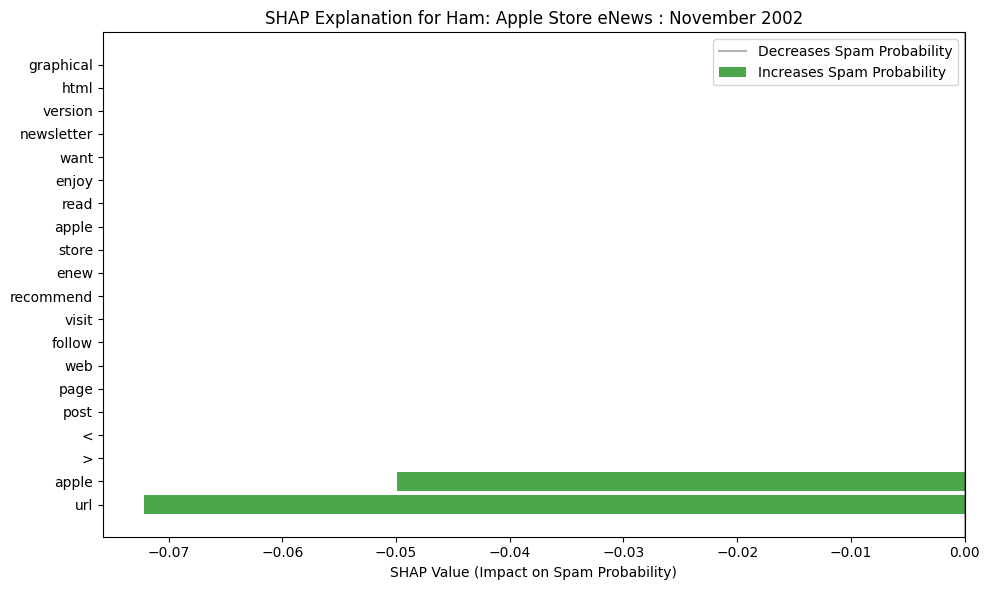

Top contributing features:
'url': -0.0722 (towards ham)
'apple': -0.0499 (towards ham)
'store': 0.0000 (towards ham)
'enew': 0.0000 (towards ham)
'november': 0.0000 (towards ham)
'2002': 0.0000 (towards ham)
'appear': 0.0000 (towards ham)
'email': 0.0000 (towards ham)
'application': 0.0000 (towards ham)
'win': 0.0000 (towards ham)


  0%|          | 0/1 [00:00<?, ?it/s]

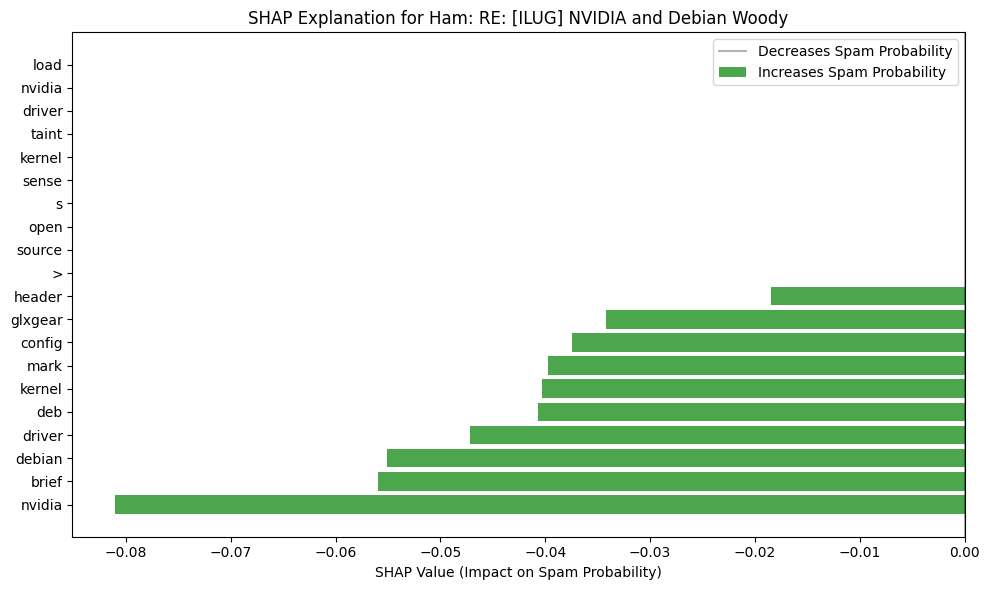

Top contributing features:
'nvidia': -0.0810 (towards ham)
'brief': -0.0560 (towards ham)
'debian': -0.0551 (towards ham)
'driver': -0.0472 (towards ham)
'deb': -0.0407 (towards ham)
'kernel': -0.0403 (towards ham)
'mark': -0.0397 (towards ham)
'config': -0.0375 (towards ham)
'glxgear': -0.0342 (towards ham)
'header': -0.0185 (towards ham)


  0%|          | 0/1 [00:00<?, ?it/s]

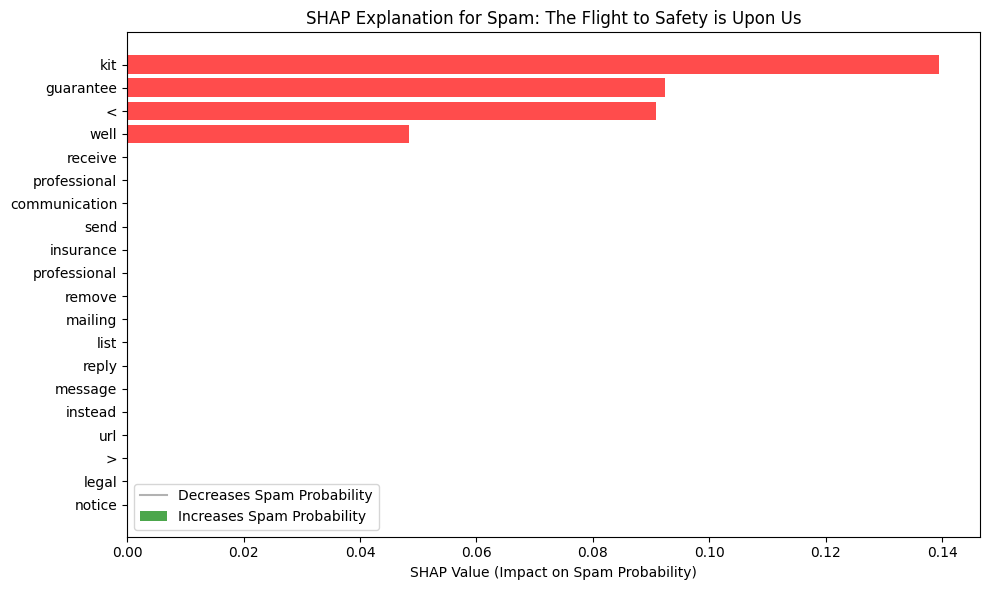

Top contributing features:
'kit': 0.1395 (towards spam)
'guarantee': 0.0924 (towards spam)
'<': 0.0908 (towards spam)
'well': 0.0484 (towards spam)
'flight': 0.0000 (towards ham)
'safety': 0.0000 (towards ham)
's': 0.0000 (towards ham)
'rush': 0.0000 (towards ham)
'hour': 0.0000 (towards ham)
'traffic': 0.0000 (towards ham)


  0%|          | 0/1 [00:00<?, ?it/s]

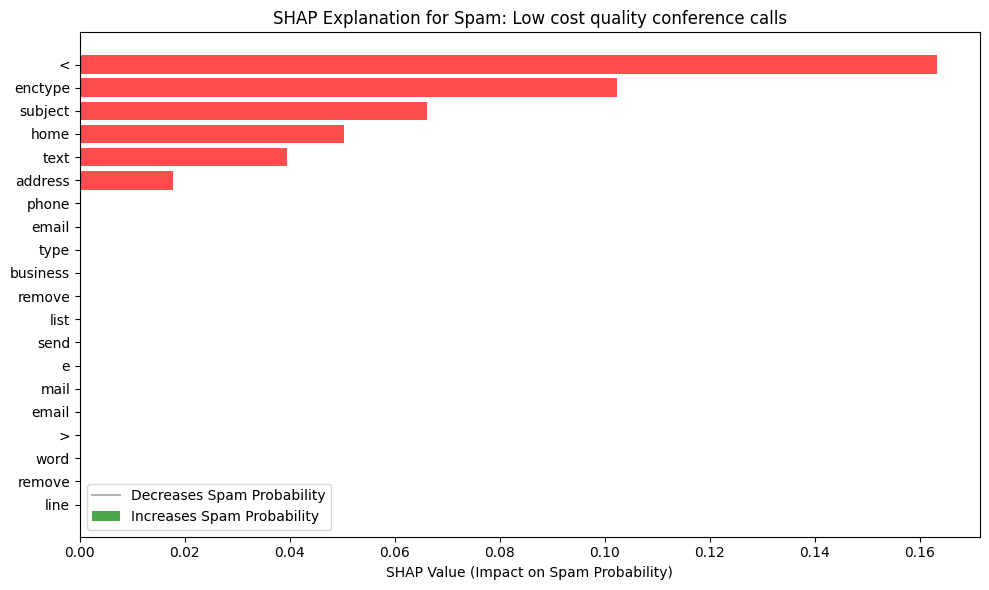

Top contributing features:
'<': 0.1633 (towards spam)
'enctype': 0.1022 (towards spam)
'subject': 0.0662 (towards spam)
'home': 0.0504 (towards spam)
'text': 0.0394 (towards spam)
'address': 0.0178 (towards spam)
'method': 0.0000 (towards ham)
'post': 0.0000 (towards ham)
'plain': 0.0000 (towards ham)
'>': 0.0000 (towards ham)


  0%|          | 0/1 [00:00<?, ?it/s]

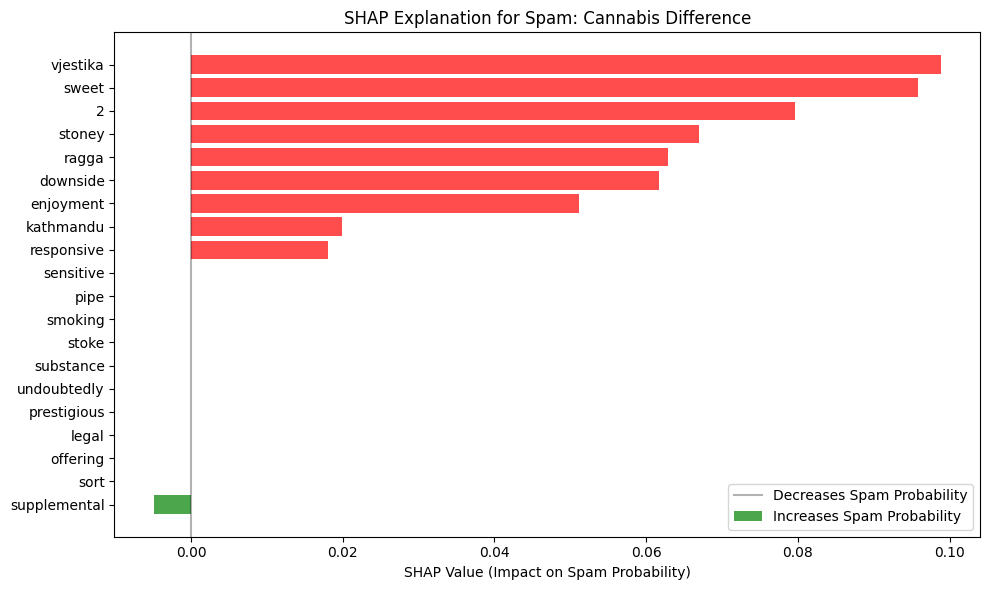

Top contributing features:
'vjestika': 0.0988 (towards spam)
'sweet': 0.0958 (towards spam)
'2': 0.0797 (towards spam)
'stoney': 0.0669 (towards spam)
'ragga': 0.0629 (towards spam)
'downside': 0.0616 (towards spam)
'enjoyment': 0.0512 (towards spam)
'kathmandu': 0.0198 (towards spam)
'responsive': 0.0180 (towards spam)
'supplemental': -0.0049 (towards ham)


In [9]:
sample_metrics = []
explanation_times = []
for sample_idx in samples:
    sample_text = test_df['text'].iloc[sample_idx]
    sample_subject = test_df['subject'].iloc[sample_idx]
    sample_label: str = ("Spam" if test_df['label'].iloc[sample_idx] == 1 else "Ham")

    # Generate explanation
    start_time = pd.Timestamp.now()
    shap_values = explainer.explain_prediction(sample_text, n_samples=100)
    end_time = pd.Timestamp.now()
    explanation_times.append((end_time - start_time).total_seconds())
    sample_metrics.append({
        'text': sample_text,
        'subject': sample_subject,
        'label': sample_label,
        'shap_values': shap_values
    })

    # Plot explanation
    explainer.plot_explanation(sample_text, shap_values, subject=sample_subject, label=sample_label)

    # Get top contributing features
    top_features = explainer.get_top_features(sample_text, shap_values, n_features=10)

    print("Top contributing features:")
    for token, shap_val in top_features:
        direction = "spam" if shap_val > 0 else "ham"
        print(f"'{token}': {shap_val:.4f} (towards {direction})")

In [ ]:
# create explanation time data frame
explanation_time_df = pd.DataFrame(explanation_times)
explanation_time_df.describe()

Computing explanation quality metrics...
Evaluating explanation quality for text: 'seeing believing url <URL> author linda grant neve...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing Rank Correlation...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


EXPLANATION QUALITY METRICS
AUC-Deletion:     0.8573 (lower is better)
AUC-Insertion:    0.1502 (higher is better)
Comprehensiveness: 0.9799 (higher is better)
Jaccard Stability: 0.3254 (higher is better)
Rank Correlation:  -0.0094 (higher is better)
Plotting deletion and insertion curves...


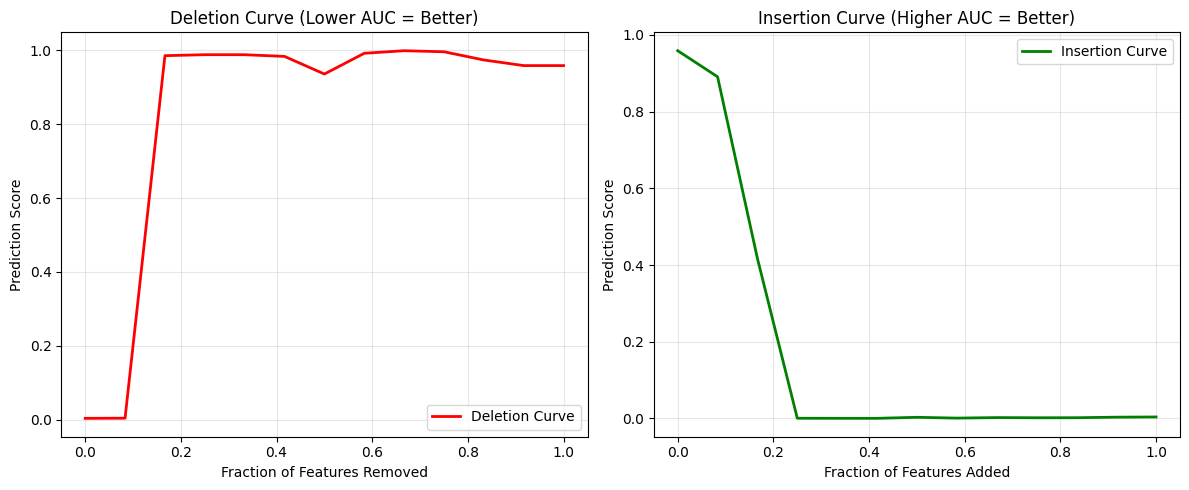

Computing explanation quality metrics...
Evaluating explanation quality for text: 'apple store enews november 2002 you appear using e...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing Rank Correlation...


/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.507e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


EXPLANATION QUALITY METRICS
AUC-Deletion:     0.5654 (lower is better)
AUC-Insertion:    0.2513 (higher is better)
Comprehensiveness: 0.0016 (higher is better)
Jaccard Stability: 0.2262 (higher is better)
Rank Correlation:  0.0992 (higher is better)
Plotting deletion and insertion curves...


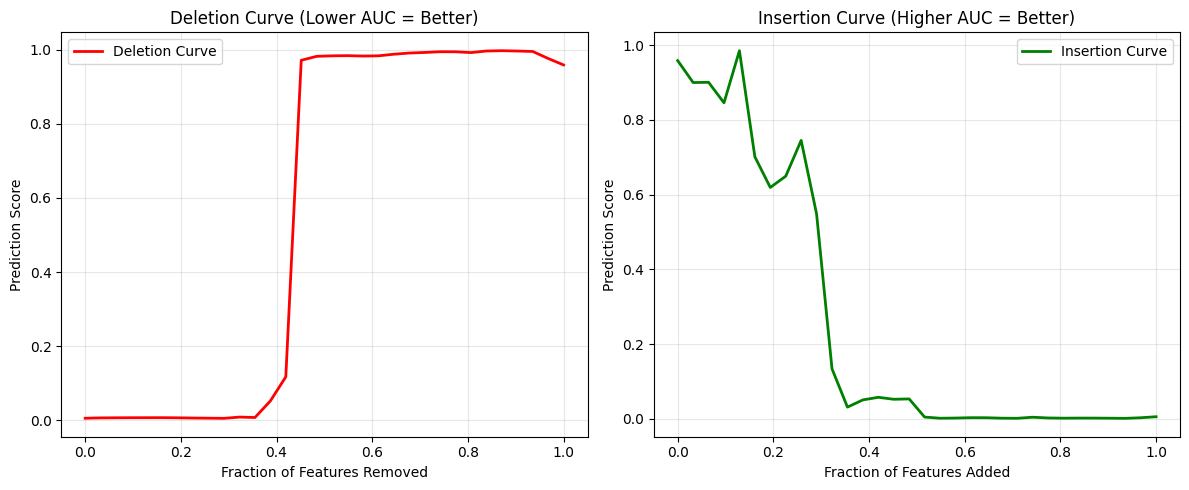

Computing explanation quality metrics...
Evaluating explanation quality for text: 're ilug nvidia debian woody hi there now probably ...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing Rank Correlation...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.101e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


EXPLANATION QUALITY METRICS
AUC-Deletion:     0.0360 (lower is better)
AUC-Insertion:    0.0225 (higher is better)
Comprehensiveness: 0.0000 (higher is better)
Jaccard Stability: 0.0444 (higher is better)
Rank Correlation:  0.0686 (higher is better)
Plotting deletion and insertion curves...


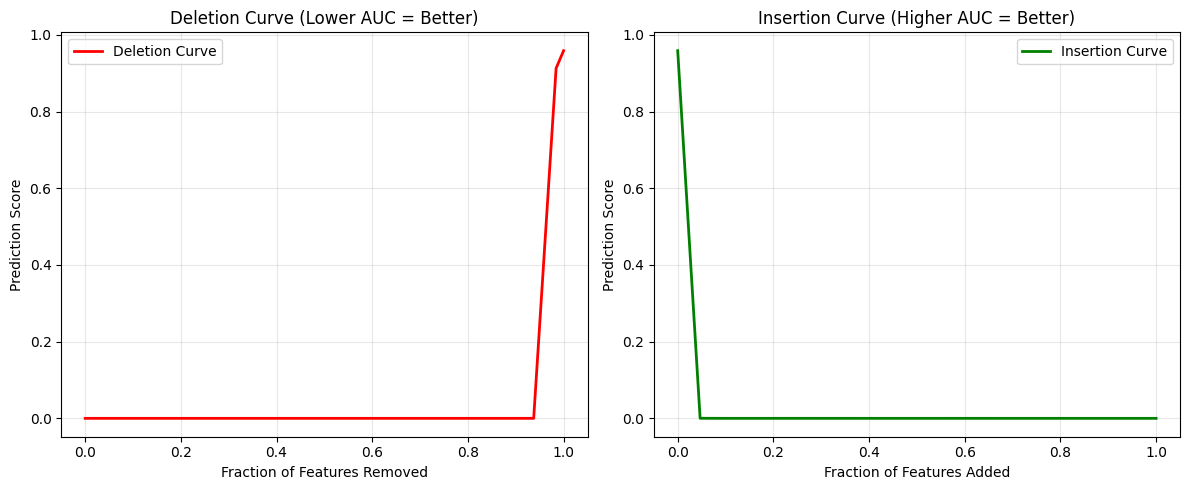

Computing explanation quality metrics...
Evaluating explanation quality for text: 'flight safety upon us s not rush hour traffic s fl...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing Rank Correlation...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


EXPLANATION QUALITY METRICS
AUC-Deletion:     0.1730 (lower is better)
AUC-Insertion:    0.9921 (higher is better)
Comprehensiveness: 0.8484 (higher is better)
Jaccard Stability: 0.1012 (higher is better)
Rank Correlation:  -0.0398 (higher is better)
Plotting deletion and insertion curves...


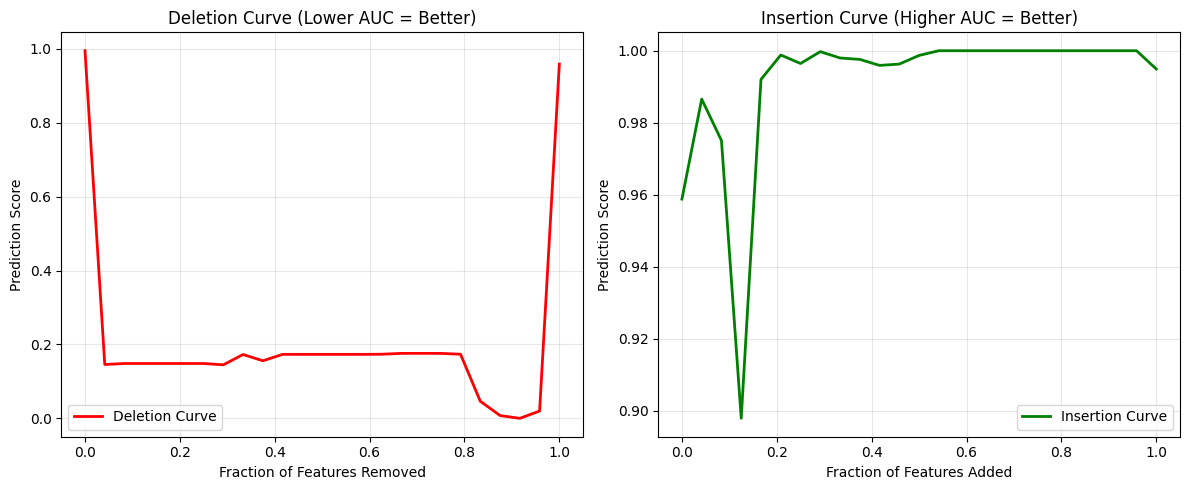

Computing explanation quality metrics...
Evaluating explanation quality for text: 'method post enctype text plain> name web address c...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing Rank Correlation...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


EXPLANATION QUALITY METRICS
AUC-Deletion:     0.8216 (lower is better)
AUC-Insertion:    0.5620 (higher is better)
Comprehensiveness: 0.0442 (higher is better)
Jaccard Stability: 0.1694 (higher is better)
Rank Correlation:  0.1372 (higher is better)
Plotting deletion and insertion curves...


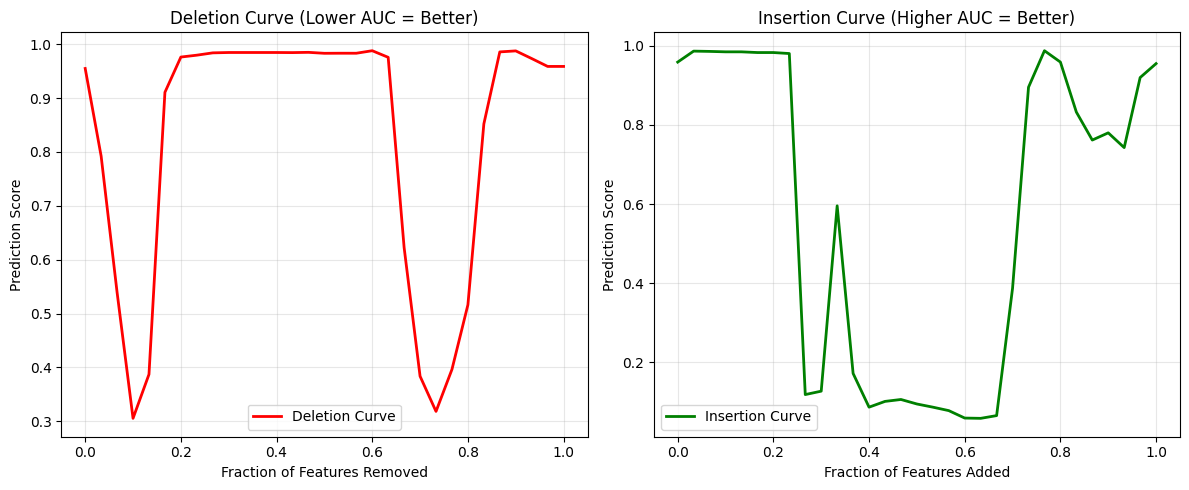

Computing explanation quality metrics...
Evaluating explanation quality for text: 'cannabis difference mid summer customer appreciati...'
Computing AUC-Del...
Computing AUC-Ins...
Computing Comprehensiveness...
Computing Jaccard Stability...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing Rank Correlation...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/michael/PycharmProjects/spam-detection/venv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.895e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


EXPLANATION QUALITY METRICS
AUC-Deletion:     0.9951 (lower is better)
AUC-Insertion:    0.9961 (higher is better)
Comprehensiveness: 0.0000 (higher is better)
Jaccard Stability: 0.0111 (higher is better)
Rank Correlation:  0.0101 (higher is better)
Plotting deletion and insertion curves...


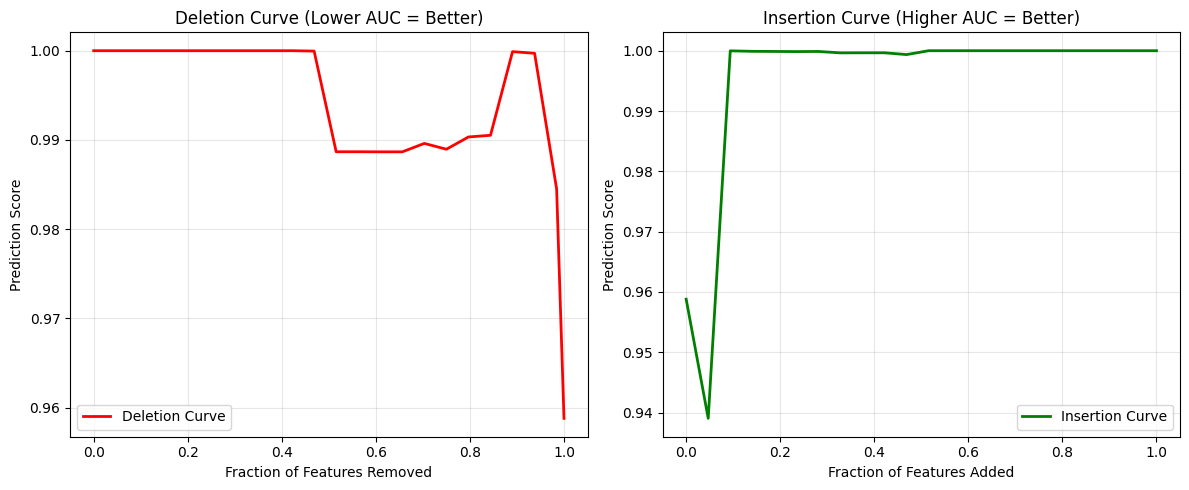

In [10]:
quality_evaluator.configure_shap_for_stability(l1_reg='num_features(10)', n_samples=100)
explanation_metrics_time = []
for sample in sample_metrics:
    print("Computing explanation quality metrics...")
    start_time = pd.Timestamp.now()
    metrics = quality_evaluator.evaluate_explanation_quality(sample['text'], sample['shap_values'])
    end_time = pd.Timestamp.now()
    explanation_metrics_time.append((end_time - start_time).total_seconds())
    print(f"Explanation quality metrics time: {explanation_metrics_time[-1]:.2f} seconds")
    print("Plotting deletion and insertion curves...")
    quality_evaluator.plot_deletion_insertion_curves(sample['text'], sample['shap_values'])
    # demonstrate_quality_metrics(explainer, sample_text)

In [ ]:
# create explanation time data frame
explanation_metrics_time_df = pd.DataFrame(explanation_metrics_time)
explanation_metrics_time_df.describe()